# LOADING LIBRARIES

In [64]:
# #pip install contractions
# # !pip install -U pip setuptools wheel
# !pip install -U spacy
#!python -m spacy download en_core_web_md
# !pip install bertopic
# !pip install yellowbrick
# !pip install distance

#https://joaopedro214.medium.com/clustering-nlp-brazilian-laws-analysis-with-tf-idf-and-k-means-c0495c7c9c5f

In [133]:
import pandas as pd
import numpy as np
import unicodedata
import re
import contractions
import string
import distance
import glob

#vis
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
import plotly.graph_objs as pgo
from tqdm import tnrange
from PIL import Image

from bokeh.plotting import figure, show, output_notebook, output_file, save
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Category10,Category20

from wordcloud import WordCloud, ImageColorGenerator
from scipy.ndimage import gaussian_gradient_magnitude




from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import AffinityPropagation
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

from sklearn import preprocessing
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import adjusted_rand_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.model_selection import train_test_split

#spacy
import spacy
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
nlp = spacy.load("en_core_web_sm")
nlp2 = spacy.load("en_core_web_md")
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer 
# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()
import textwrap
stops = set(stopwords.words('english'))

from bertopic import BERTopic

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ankush.singal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ankush.singal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ankush.singal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/ankush.singal/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# LOADING THE DATA

In [4]:
def load_data(): 
    df_all = pd.read_csv('Created_Cases - databricks.csv')
    # Take a subset
    return df_all.loc[:, ["Case title","Session Id"]]
df = load_data()
df.rename(
    columns=({ 'Case title': 'Case_title', 'Session Id': 'Session_Id'}), 
    inplace=True,
)
df.head()

,Case_title,Session_Id
0,genie,1654038670643245
1,genie,1654040144291671
2,jproperties library installation issue,1654038759243102
3,Union with Null,1654032363233406
4,Spark ReadStream fails to infer schema,1654030825979675


In [5]:
#https://www.codegrepper.com/code-examples/python/remove+rows+that+contain+string+pandas
df1 = df[df["Case_title"].str.contains("Genie|genie|Gnie") == False]
df1.reset_index(inplace = True)
del df1['index']
df1

,Case_title,Session_Id
0,jproperties library installation issue,1654038759243102
1,Union with Null,1654032363233406
2,Spark ReadStream fails to infer schema,1654030825979675
3,Unable to execute Notebook commands,1654030565271692
4,ARR Customer CVS: Issue - Unable to grant read...,1654029928833435
...,...,...
5599,"After purging cluster logs, there is no signif...",1646101446712964
5600,Trying to connect MicroStrategy iserver DB con...,1646098742869832
5601,Databricks Shard Upgrade 3.60 Support!,1646098948333606
5602,Cluster crash weekly,1646096936896602


In [6]:
df11 = df1.copy()

In [7]:
# len(df)

In [8]:
len(df11)

5604

In [9]:
vec = TfidfVectorizer(stop_words='english')
X1 = vec.fit_transform(df11.Case_title)

In [10]:
X1.shape

(5604, 5241)

In [11]:
# #https://stackoverflow.com/questions/71525534/i-got-error-valueerror-could-not-convert-string-to-float
df2 = pd.DataFrame(X1.toarray(), columns=vec.get_feature_names())

In [12]:
df11.drop(['Case_title'], axis=1,inplace=True)

In [13]:
df3 = pd.concat([df1, df2], axis=1)
#df3.head()
df3.shape

(5604, 5243)

In [14]:
# df2 = pd.DataFrame(
#     X1.toarray(),
#     df1.Session_Id,
#     df1.time
#     )

# KL DIVERGENCE

# 1. Take the Transpose:
I have taken the transpose of my dataset and have applied further steps on the transpose because it is giving somewhat good separable clusters.

In [15]:
# # Transposed_Dataset = df3.T
# Transposed_Dataset.head()

# 2. Scale the Dataset:

Since we will be working on an unsupervised learning model and it works badly on low data.
Hence, there is a need to scale the data before feeding it to the k-means algorithm.

In [16]:
# # Used preprocessing module of sklearn library to scale data.
# X_scaled = preprocessing.scale(Transposed_Dataset)
# len(X_scaled)

# 3. Standardize the Dataset:

In order to ensure internal consistency of the data means each data type will have the same content and format.
Standardized values are useful for tracking data that isn’t easy to compare otherwise.

In [17]:
# X_std = StandardScaler().fit_transform(X_scaled)

# 4. Check uniformity of the Dataset:

I have checked the uniformity of both datasets using the KL divergence test.
I have checked the KL test just for having an idea of distributions, we are not comparing distributions here.
The KL divergence is zero if two distributions are equal.
The KL divergence is positive if two distributions are different.
To find the KL divergence of two datasets, the below function has been used.

In [18]:
# df_variance = df3.var() # Calculating variance for each feature of dataframe
# df_mean = df3.stack().mean() # Calculating mean for each feature of dataframe
# trans_mean = Transposed_Dataset.stack().mean() # Calculating mean for each feature of transpose
# trans_variance = Transposed_Dataset.var() # Calculating variance for each feature of transpose
# df_std = df3.stack().std()   # Calculating standard deviation for each feature of dataframe
# trans_std = Transposed_Dataset.stack().std() # Calculating standard deviation for each feature of transpose
        
# def kl_divergence(p, q):
#     return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [19]:
# from scipy.stats import norm

In [20]:
# def df_normal_dist():
#     x = np.arange(-10, 10, 0.001)
#     dp = norm.pdf(x, df_mean, df_std) 
# #     dq = norm.pdf(x, 0, 1) 
#     # Taking KL divergence b/w Dataframe distribution & normal distribution.
#     plt.title('KL(P||Q) = %1.3f' % kl_divergence(dp, dq))
#     plt.plot(x, dp)
#     plt.plot(x, dq, c='red')
# df_normal_dist()

# Conclusion of applying Uniformity Distribution:

I have first compared plots of each dataset with that of normal distribution because I was getting bell-shaped distributions for each dataset.
From the above graph, one can easily conclude that the dataset is not distributed uniformly since we are getting some bell-shaped curves.
So, we can apply the K-Means algorithm easily.
Once we have checked all the conditions and made the required improvements in the limitations whatsoever, we can move further to apply the K-Means algorithm on our prepared dataset.

# PREPROCESSING OF THE DATA 

# Feature Extraction with TF-IDF
Cutting terms below 0.5% document frequency
Remove english stopwords

In [65]:
# Group by Session_ID
grouped_df = df1.groupby('Session_Id').agg({'Case_title':list})
 
# Join all queries in a cases
grouped_df['Case_title'] = grouped_df['Case_title'].apply(lambda x: ' '.join(x))
 
# Create a list of grouped queries
# for each title. 
queries = list(grouped_df['Case_title'])
queries

['Security Alert  for connectivity from AWS account owned by Databricks',
 'Cluster crash weekly',
 'Trying to connect MicroStrategy iserver DB connection to Databricks',
 'Databricks Shard Upgrade 3.60 Support!',
 'ARR | 2202280060001228 | RCA | Job that was triggered by Data Factory failed due to cluster inactivity  ',
 'After purging cluster logs, there is no significant change in size. What are the other items that constitute the storage?',
 '2201250060001153 2202240030000948',
 'ARR followup - 00132690',
 'Error in data bricks - ConnectException: Connection refused (Connection refused)  Error while obtaining a new communication channel',
 'Integrate Power Apps with Azure Databricks - Connector',
 '2202240030000721001',
 'Remote RPC client disassociated',
 'one AWS account for multiple databricks workspace',
 'SSL error',
 'The spark jobs are taking longer time to start up',
 'Sample case for testing',
 'Issue with notebook execution ',
 'job cluster config change does not take aff

In [66]:
tfidf_vec = TfidfVectorizer(min_df=0.005, 
                            stop_words=nltk.corpus.stopwords.words('english') ) 
data_tfidf = tfidf_vec.fit_transform(queries).todense()
pca = PCA( 0.95, random_state=2140)
data_pca = pca.fit_transform(data_tfidf)

In [67]:
print( f"TF-IDF dimension - {data_tfidf.shape[1]}" )
print( f"TF-IDF + PCA dimension - {data_pca.shape[1]}" )

TF-IDF dimension - 194
TF-IDF + PCA dimension - 164


# Visualizing more important terms

In [68]:
N_WORDS = 30
mean_data_tfidf = np.array( data_tfidf.mean( axis=0 ) ).flatten()
vocabulary = tfidf_vec.get_feature_names()
words_id = np.flip( mean_data_tfidf.argsort()[-N_WORDS:] )

word_val_data = [ (vocabulary[id], mean_data_tfidf[id]) for id in words_id ]
word_val_data = pd.DataFrame(word_val_data, columns=['words','values'])

Text(0.5, 1.0, 'Top-30 most important words')

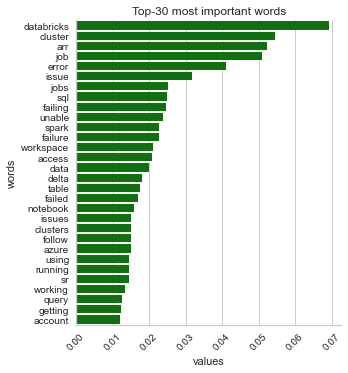

In [69]:
g = sns.catplot(data=word_val_data, color='green',
                 x='values', y='words', kind='bar' )
g.ax.tick_params(axis='x', rotation=45)
g.ax.set_title( f"Top-{N_WORDS} most important words" )

In [70]:
print( data_tfidf.shape )
print( data_pca.shape )

(5020, 194)
(5020, 164)


# Clustering with K-means
Selecting number of clusters

In [71]:
cluster_sizes = range(2, 20+1)
kmeans_models = [ KMeans(i, n_init=20, random_state=2140) for i in cluster_sizes ]
cluster_score = []

for kmeans in kmeans_models:
  y = kmeans.fit_predict(data_pca)
  score = silhouette_score(data_pca, y)
  cluster_score.append( ( kmeans.n_clusters, score) )

cluster_score=np.array(cluster_score)

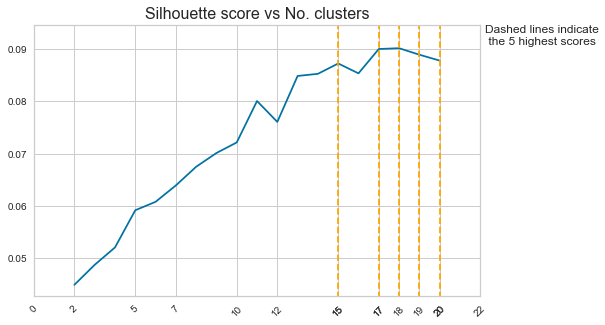

In [72]:
scores = cluster_score[:, 1]
clusters = cluster_score[:, 0]
max_score_clusters = []

fig, ax = plt.subplots( figsize=(8,5) )
ax = sns.lineplot( x=clusters, y=scores, ax=ax )
ax.set_title("Silhouette score vs No. clusters", fontsize=16)

for i in np.argsort( scores )[-5:]:
  ax.vlines(clusters[i], 0, 1, linestyles='--', colors='orange')
  max_score_clusters.append( clusters[i] )

ax.text(1.01, 1, f"Dashed lines indicate\n the {len(max_score_clusters)} highest scores",
        transform=ax.transAxes, ha='left', va='top')

xticks = ax.get_xticks().astype(int)
xticks = np.append(xticks, max_score_clusters)
ax.set_xticks( xticks )
ax.tick_params(axis='x', rotation=45)

ax.set_ylim( [ 0.95*min(scores), 1.05*max(scores) ] )
ax.set_xlim( [ 0, max(clusters)+2 ] )

plt.show()


In [102]:
n_clusters=11
kmeans_model = KMeans(n_clusters, n_init=20, random_state=2140)
y = kmeans_model.fit_predict(data_pca)

# Results visualization
Silhouette samples

In [103]:
sample_scores = silhouette_samples( data_pca, y )
sample_scores_df =  pd.DataFrame( data = {'Cluster':y, 'Silhouette':sample_scores} )
sample_scores_df = sample_scores_df.reset_index()
sample_scores_df=sample_scores_df.sort_values('Silhouette', ascending=False)


In [104]:
sample_scores_df

,index,Cluster,Silhouette
4300,4300,7,0.509948
4968,4968,7,0.509948
3974,3974,7,0.509948
3872,3872,7,0.509948
358,358,7,0.509948
...,...,...,...
4454,4454,6,-0.084096
2195,2195,10,-0.086207
4722,4722,10,-0.090689
1316,1316,10,-0.093844


In [105]:
def plot_silhouette_samples(X, pred_labels):
  n_clusters = len(np.unique(pred_labels))

  fig, (ax) = plt.subplots(1, 1, figsize=(8,8))
  
  ax.set_xlim([-0.1, 1])
  ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])

  silhouette_avg = silhouette_score(X, pred_labels)
  sample_silhouette_values = silhouette_samples(X, pred_labels)

  y_lower = 10
  for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[pred_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
  
    ax.fill_betweenx(np.arange(y_lower, y_upper), 
                     0, ith_cluster_silhouette_values )
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i),
            ha='center', va='center', fontsize=12,
            bbox={'boxstyle':'square',
                  'facecolor':'white'})
    y_lower = y_upper + 10
  
  ax.set_title(f"The silhouette score plot for the {n_clusters} clusters.\n",fontsize=20)
  ax.set_xlabel("Silhouette coefficient values",fontsize=18)
  ax.set_ylabel("Cluster",fontsize=18)
  ax.axvline(x=silhouette_avg, color="red", linestyle="--")
  ax.set_yticks([])
  ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

  return ax

<AxesSubplot:title={'center':'The silhouette score plot for the 11 clusters.\n'}, xlabel='Silhouette coefficient values', ylabel='Cluster'>

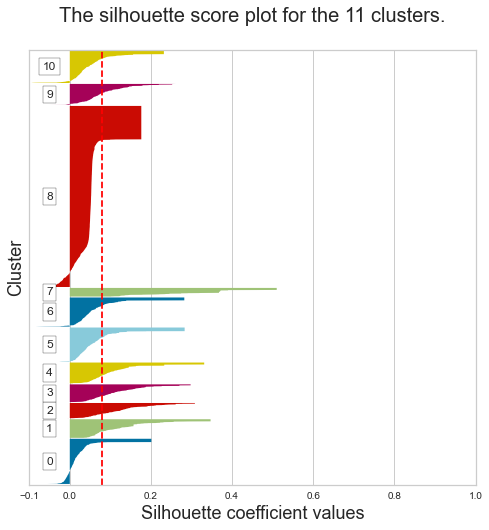

In [106]:
plot_silhouette_samples(data_pca, y)

In [107]:
texts_original = df1['Case_title']

np.random.seed(214)
N_SAMPLE = 3

text_ex = pd.DataFrame( columns=['text', 'Cluster', 'Id' ] )

for i in range( kmeans_model.n_clusters ):
  for id, e in enumerate( texts_original[ np.random.choice( np.argwhere(y==i).flatten(), size=N_SAMPLE ) ] ):
    text_ex.loc[i*N_SAMPLE + id] = [e, i, id]

pd.set_option('display.max_colwidth', 100)
text_ex.set_index(['Cluster', 'Id'])


text
Cluster Id                                                                                                     
0       0                                                              Hyperopt x.x.x.dbx on customized cluster
        1                                                                       ARR - Slowness in Delta tables 
        2                                             ARR | issues authenticating  with PAT | 2203100040006496 
1       0                                     Databricks repos - Seeing changed/modified files in the repos tab
        1                                                                       EU-West-2 and EU-Central-1 down
        2                                                              Spark driver issues when triggering job 
2       0                                                           Feature store doesn't allow nullable fields
        1                                                                           Enable audit logging in PVC
        2                      Need help validating audit logs - CSET tool audit is not working for west europe
3       0                                                                                     2204040040006958 
        1                                                                  Download files from S3 bucket in Dev
        2                                                                            RDS error on control plane
4       0   While Reading CSV files from datalake to databricks it is creating distorted data in notebookRea...
        1                                  Production jobs are failing due to Connection Timedout to Databricks
        2                                                                            "lag() ignore nulls" broke
5       0                                                 java.lang.ClassCastException when we try runtime 10.5
        1                                                Could not create private workspace in azure databricks
        2                                                                                    00142694 follow up
6       0                                                                                      2204280040006201
        1                                                                                   SQL Analytics Issue
        2                                                     Table or View not found on Warehouse SQL Endpoint
7       0   CSS-ARR-S500-SR#2203230030000992-Need help to enable feature to create private workspace in subs...
        1                                                              Informatica job is failing in Databricks
        2                                                                 load excel(xlsx) file into dataframe?
8       0                             Databricks Notebook taking longer time moveing the data from ADLS to ADLS
        1                                                                        2205060010001700 | Job Failure
        2                           The jobs fail when attempting to distribute this workflow into Worker Nodes
9       0                                                                              Test email notification 
        1                                    Issues in viewing the MLFLOW Experiments from Databricks MLFlow UI
        2                                                              Network Configuration Update Not Working
10      0                                    Databricks gapply function in R corrupts data with bigint datatype
        1                            9117 - ARR - tmobile - Customer is seeing duplicates in their Delta merges
        2                                                             worker cannot be registered to the driver

# Most Important words in each cluster

In [108]:
def most_important_words(data_tfidf, y, topn=10):

  n_clusters = len(np.unique(y))
  result = []
  for i in range(n_clusters):
    ith_cluter_word_sum = np.mean(data_tfidf[np.argwhere(y==i).flatten()], axis=0)
    
    word_ids = np.array( np.argsort( ith_cluter_word_sum )[0, -topn:] )
    word_ids = word_ids.reshape( -1 )
    result = result + [ (i, id, ith_cluter_word_sum[0, id] ) for id in word_ids ]

  return result

In [109]:
word_cluster_df = pd.DataFrame( most_important_words( data_tfidf, y, topn=5 ), columns=["Cluster", "WordId", "Score"] )
word_cluster_df["Word"] = word_cluster_df["WordId"].apply( lambda id: tfidf_vec.get_feature_names()[id] )
word_cluster_df = word_cluster_df.sort_values( "Score", ascending=False )
word_cluster_df.head()

,Cluster,WordId,Score,Word
39,7,70,0.678222,follow
24,4,86,0.538561,issue
19,3,62,0.521288,failing
29,5,20,0.477679,cluster
49,9,154,0.471800,sql


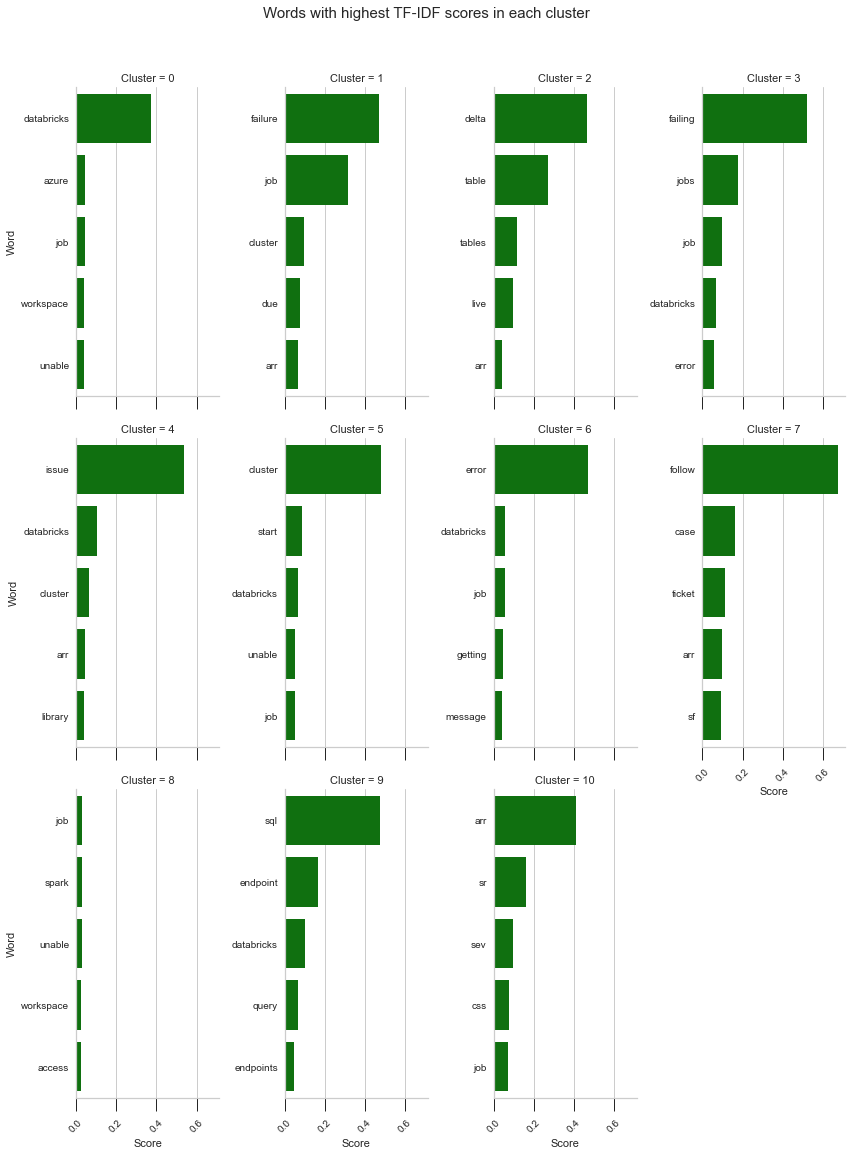

In [110]:
g = sns.catplot(x="Score", y="Word", col="Cluster", data=word_cluster_df, 
                sharey=False, col_wrap=4, kind="bar",
                color = 'green', aspect=.6)
[ ax.tick_params(axis='x', rotation=45, size=13) for ax in g.axes.flatten() ]
g.fig.suptitle( "Words with highest TF-IDF scores in each cluster", y = 1.05, fontsize=15 )
plt.show()

# 2D view of clusters and data with U-Map

In [111]:
!pip install umap-learn

In [112]:
import umap
output_notebook()

/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/bokeh/io/notebook.py:487: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  publish_display_data(data, metadata, source, transient=transient, **kwargs)


Loading BokehJS ...

/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/bokeh/io/notebook.py:487: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  publish_display_data(data, metadata, source, transient=transient, **kwargs)


In [135]:
# c_pallete = list(Category20)
# len(c_pallete)

18

In [138]:
umap_red = umap.UMAP(n_neighbors=12, metric='correlation', 
                     random_state=214)
data_2d = umap_red.fit_transform( data_pca )

In [140]:
data_2d_df = pd.DataFrame( data={"x":data_2d[:, 0], 
                                 "y":data_2d[:, 1], 
                                 "Cluster":y,
                                 "Silhouette":sample_scores } )


c_pallete = list(Category20[11])
c_pallete[7], c_pallete[0] = c_pallete[0], c_pallete[7]

data_2d_df['colors'] = [ c_pallete[i] for i in data_2d_df['Cluster']]
data_2d_df['Case_title'] = df1['Case_title']
# #Limiting the text's size
data_2d_df['Case_title'] = data_2d_df['Case_title'].apply( lambda s: s[:100]+'...' if len(s)>100 else s )

data_2d_df, _,_,_ = train_test_split(data_2d_df, data_2d_df, train_size=4500, stratify=data_2d_df['Cluster'])

data_2d_cdf = ColumnDataSource(data_2d_df)


In [141]:
fig = figure(
    title='UMAP 2D projection of the points and clusters',
    plot_width=600,
    plot_height=600,
    tools=('pan, wheel_zoom, reset', 'save')
)

fig.add_tools(HoverTool(tooltips="""
                                      <div>
                                        <span style='font-size: 10px; color: @colors'>@ementa</span>
                                        <span style='font-size: 10px'>cluster - </span>
                                        <span style='font-size: 10px'>@Cluster ;</span>
                                        <span style='font-size: 10px'>index - </span>
                                        <span style='font-size: 10px'>$index ;</span>
                                        <span style='font-size: 10px'>silhouette: </span>
                                        <span style='font-size: 10px'>@Silhouette</span>
                                      </div>
                                 """)
              )

fig.circle('x','y', source=data_2d_cdf, color='colors', 
           legend_group="Cluster",
           line_alpha=0.6, fill_alpha=0.6, size=2)

show(fig)
save(fig, "UMAP2D.html")

/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/bokeh/io/notebook.py:487: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  publish_display_data(data, metadata, source, transient=transient, **kwargs)


/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/bokeh/io/notebook.py:487: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  publish_display_data(data, metadata, source, transient=transient, **kwargs)


'/Users/ankush.singal/UMAP2D.html'

# Word Clouds for fancier vocabulary visualizations

In [88]:
wc_stopwords = nltk.corpus.stopwords.words('english')
texts = df1['Case_title']

In [89]:
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
  c = congress_mask[ position[0], position[1] ]
  # Paint word with a solid color from the point where it was written
  # the native function of WordCloud use the mean color from neighbours points
  # and its very messy

  return f"rgb({c[0]}, {c[1]}, {c[2]})"

def color_func2(word, font_size, position, orientation, random_state=None, **kwargs):
  # Paint non-white words with a constant color
  c = congress_mask[ position[0], position[1] ]
  if ( ([255,255,255] - c).sum() > 10 ):
    c = [50, 144, 252]
  return f"rgb({c[0]}, {c[1]}, {c[2]})"

# Just change the blues and greens of the image to a fancier version 
def color_func3(word, font_size, position, orientation, random_state=None, **kwargs):
  c = congress_mask[ position[0], position[1] ]

  ## Changes the green
  if ( np.abs([  0, 139, 211] - c).sum() < 10 ):
    c = [71, 148, 255]
  ## Changes the green
  elif ( np.abs([ 81, 175,  53] - c).sum() < 10 ):
    c = [86, 184, 77]
  else:
    pass

  return f"rgb({c[0]}, {c[1]}, {c[2]})"

# Opening the image and transforming it in a numpy array
congress_img = np.array( Image.open('congresso_nacional_logo_02.jpg') )
congress_mask = congress_img.copy()

# Calculating the image edges
edges = np.mean([gaussian_gradient_magnitude(congress_mask[:, :, i] / 255., 2) for i in range(3)], axis=0)

# Masking the edges out
mask = edges > .05
mask_w = np.zeros( ( mask.shape[0], mask.shape[1], 4 ) )
mask_w[ :, : ] = [0,0,0,255] # All the mask is black
mask_w[ mask ] = 255 # Except for the edges, that are White

(-0.5, 1160.5, 579.5, -0.5)

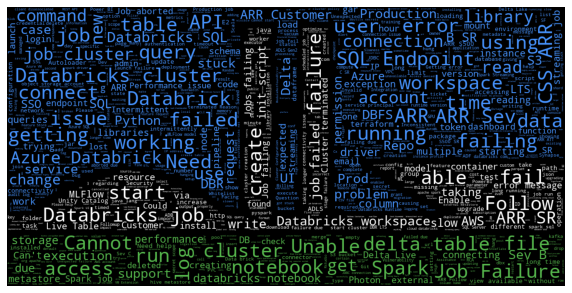

In [90]:
fig, ax = plt.subplots(figsize=(10, 10), )

# Stopwords for wordcloud
wc_stopwords = nltk.corpus.stopwords.words('english')

# Creating the word cloud
wc = WordCloud(max_words=1000, mask=mask_w, 
               max_font_size=40, min_font_size=4,
               random_state=214, repeat=True, 
               stopwords=wc_stopwords)
# Fitting 
wc.generate_from_text( ' '.join(texts.to_list()) )

# Recoloring WordCloud
wc.recolor(color_func=color_func3)
ax.imshow(wc)
ax.axis('off')

(-0.5, 1160.5, 579.5, -0.5)

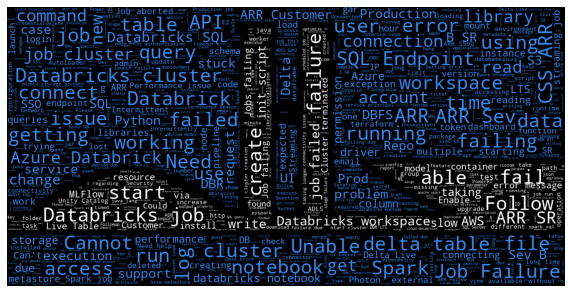

In [92]:
fig, ax = plt.subplots(figsize=(10, 10), )
image_colors = color_func2
wc.recolor(color_func=color_func2)
ax.imshow(wc)
ax.axis('off')

(-0.5, 1160.5, 579.5, -0.5)

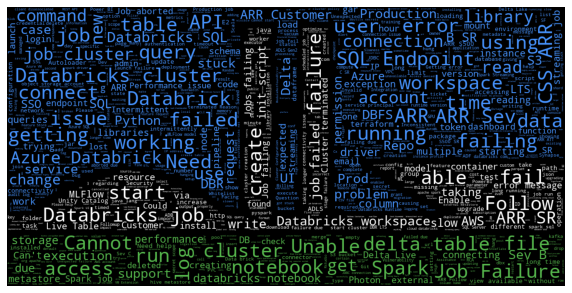

In [93]:
fig, ax = plt.subplots(figsize=(10, 10), )
wc.recolor(color_func=color_func3)
ax.imshow(wc)
ax.axis('off')

# Word Clouds for fancier (cluster x vocabulary) visualizations

In [94]:
def generate_colorfunc( img ):
  return lambda word, font_size, position, orientation, random_state=None, **kwargs: f"rgb({img[position[0]][position[1]][0]}, {img[position[0]][position[1]][1]}, {img[position[0]][position[1]][2]})"


def generate_colorfunc_replace_color( img, color ):
  # replace any color far away from white with a constant color
  img[ ([255,255,255] - img).sum(axis=2) > 20 ] = color

  # Build a function to generate colors
  return lambda word, font_size, position, orientation, random_state=None, **kwargs: f"rgb({img[position[0]][position[1]][0]}, {img[position[0]][position[1]][1]}, {img[position[0]][position[1]][2]})"

In [95]:
## Split the mask into the pre-defined number of pieces
def split_mask_into_pieces(mask, pieces=10):
  mask = np.split( mask[:,  :pieces*(mask.shape[1]//pieces)], indices_or_sections=pieces, axis=1 )
  return mask

## Building a data frame with the mean tf-idf scores
## of each word in each cluster
word_cluster_full_df = pd.DataFrame(most_important_words( data_tfidf, y, topn=25 ), 
                                    columns=["Cluster", "WordId", "Score"] )
word_cluster_full_df["Word"] = word_cluster_full_df["WordId"].apply( lambda id: tfidf_vec.get_feature_names()[id] )

In [96]:
## Adding a few extra lines to the top and botton of the figure,
## Just to make it look nicer
congress_mask = np.vstack( [np.repeat(congress_mask[[-1], :, :], 300, axis=0), congress_mask] )
congress_mask = np.vstack( [congress_mask, np.repeat(congress_mask[[-1], :, :], 50, axis=0)] )

mask_w = np.vstack( [np.repeat(mask_w[[-1], :, :], 300, axis=0), mask_w] )
mask_w = np.vstack( [mask_w, np.repeat(mask_w[[-1], :, :], 50, axis=0)] )

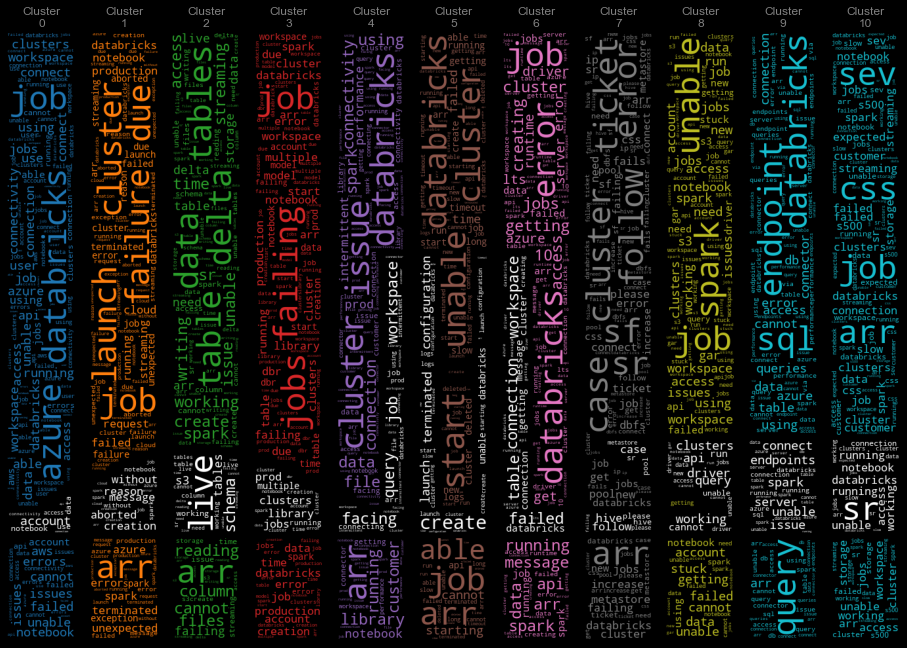

In [97]:
# Mask and color splits
mask_ws = split_mask_into_pieces(mask_w, pieces=n_clusters)
color_s =split_mask_into_pieces(congress_mask, pieces=n_clusters)

# Setting a color for each cluster
cluster_colors = [ plt.get_cmap('tab10')(i) for i in range(n_clusters) ]
# this transformation is done because matplotlib stores RGB in range 0-1
cluster_colors = [ (255*c[0], 255*c[1], 255*c[2]) for c in cluster_colors ]

# Creating the matplotlib axes to plot the WordClouds
fig, axs = plt.subplots( nrows = 1, ncols=n_clusters, figsize = (16,16) )
fig.patch.set_facecolor('black')

# A list to store the word clouds rendered
wcs = []

for i in range(n_clusters):
  
  ## Building words importance for each cluster
  word_scores = word_cluster_full_df.query(f"Cluster == {i}")
  word_scores = word_scores.set_index("Word").drop( ["Cluster","WordId"],axis=1 )
  word_scores = word_scores.to_dict()['Score']

  ## Creating the word cloud
  wc = WordCloud(max_words=150, mask=mask_ws[i], 
                 max_font_size=50, min_font_size=4,
                 random_state=214, repeat=True,
                 stopwords=wc_stopwords)
  
  ## Fitting the Word cloud
  wc.generate_from_frequencies( word_scores )

  ## Recolor each cluster with its respective color
  wc.recolor(color_func= generate_colorfunc_replace_color(color_s[i], cluster_colors[i][:3]) )
  wcs.append(wc)

  ## Plotting
  axs[i].imshow( wc )
  axs[i].axis('off')
  axs[i].set_title(f"Cluster\n{i}", color='Grey')

# 2D projection of clusters and data with U-Map
Finally, we are going to make our last contribution to data visualization by plotting the data points in 2D using a dimensionality reduction technique.

For this, we are going to use the Bokeh library, since it allows us to make nice interactive graphics with HTML formatting.

The dimensionality reduction is made using the UMAP algorithm, provided by the library with the same name.

In [91]:
## Reduction using UMAP
umap_red = umap.UMAP(n_neighbors=12, metric='correlation', 
                     random_state=214)
data_2d = umap_red.fit_transform( data_pca )